In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy.ndimage

import pandas as pd

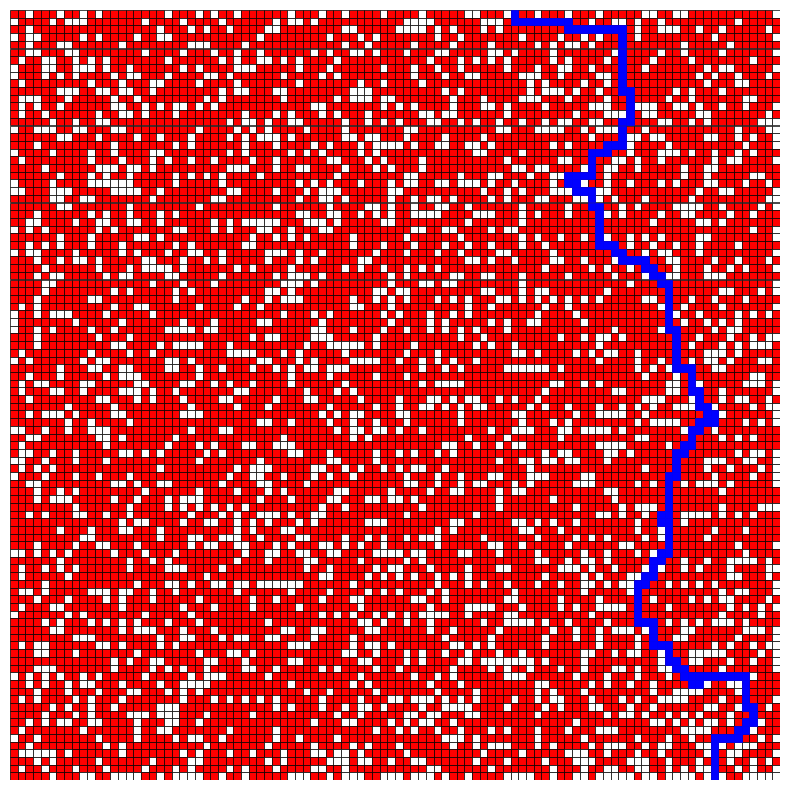

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import networkx as nx

def generate_grid(N, M, p):
    # Bernoulli rvs
    h_grid = np.random.rand(N, M - 1) < p  # Horizontal connections (N rows, M-1 columns)
    v_grid = np.random.rand(N - 1, M) < p  # Vertical connections (N-1 rows, M columns)
    return h_grid, v_grid

def find_percolation_path(h_grid, v_grid):
    N, M_minus_one = h_grid.shape
    N_minus_one, M = v_grid.shape
    
    # Create a graph to represent the connections
    G = nx.Graph()
    
    # Add nodes
    for y in range(N):
        for x in range(M):
            G.add_node((y, x))
    
    # Add edges for horizontal connections
    for y in range(N):
        for x in range(M - 1):
            if h_grid[y, x]:
                G.add_edge((y, x), (y, x + 1))
    
    # Add edges for vertical connections
    for y in range(N - 1):
        for x in range(M):
            if v_grid[y, x]:
                G.add_edge((y, x), (y + 1, x))
    
    # Find a percolation path
    for start in range(M):  # Start from top row
        for end in range(M):  # End at bottom row
            try:
                path = nx.shortest_path(G, source=(0, start), target=(N - 1, end))
                return path  # Return the first found path
            except nx.NetworkXNoPath:
                continue
    
    return None  # No percolation path found

def plot_grid(h_grid, v_grid, path):
    N, M_minus_one = h_grid.shape
    N_minus_one, M = v_grid.shape
    
    fig, ax = plt.subplots(figsize=(10, 10 * (N / M)))
    
    for y in range(N):
        for x in range(M):
            cell_color = 'white'  # Closed by default
            
            # Check horizontal connection
            if x < M_minus_one and h_grid[y, x]:
                cell_color = 'red'  # Horizontal connection to the right
                
            # Check vertical connection
            if y < N_minus_one and v_grid[y, x]:
                cell_color = 'red'  # Vertical connection downward
                
            # Add the rectangle patch with the determined cell color
            ax.add_patch(Rectangle((x, y), 1, 1, edgecolor='black', facecolor=cell_color, lw=0.5))
    
    if path:
        for (y, x) in path:
            rect = Rectangle((x, y), 1, 1, edgecolor='blue', facecolor='blue', lw=0.5)
            ax.add_patch(rect)

    ax.set_xlim(0, M)
    ax.set_ylim(0, N)
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()
    plt.axis('off')  # Hide the axes
    plt.savefig('Percolation_Path.png')
    plt.show()

N = 100  # Number of rows
M = 100  # Number of columns
p = 0.5  # Probability of an open site

h_grid, v_grid = generate_grid(N, M, p)
path = find_percolation_path(h_grid, v_grid)
plot_grid(h_grid, v_grid, path)


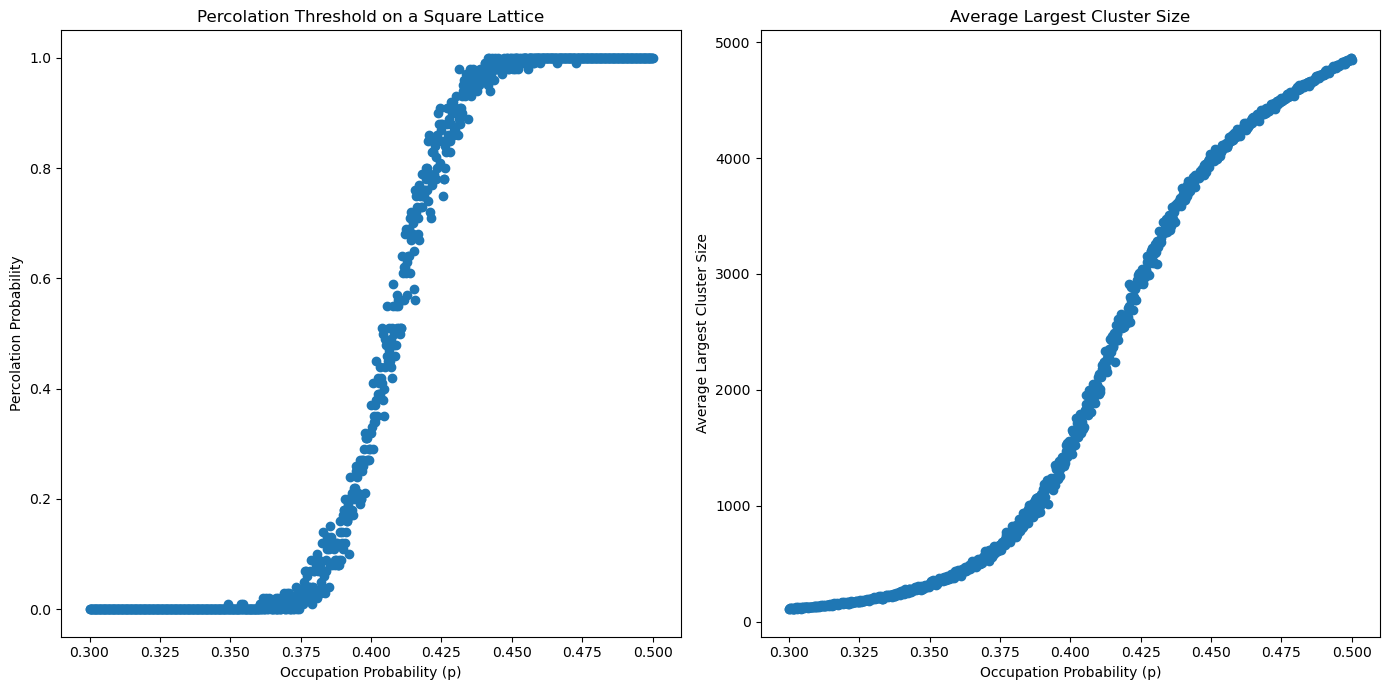

In [3]:
class Percolation:
    def __init__(self, size, p):
        self.size = size
        self.p = p
        self.lattice = np.random.rand(size, size) < p
        self.structure = np.array([[1, 1, 1],
                                   [1, 1, 1],
                                   [1, 1, 1]])  # Moore neighborhood
    
    def find_clusters(self):
        labeled, num_clusters = scipy.ndimage.label(self.lattice, structure=self.structure)
        
        # Handle toroidal connections
        # merging clusters that span the edges
        for i in range(self.size):
            if labeled[0, i] != 0 and labeled[-1, i] != 0:
                labeled[labeled == labeled[-1, i]] = labeled[0, i]
            if labeled[i, 0] != 0 and labeled[i, -1] != 0:
                labeled[labeled == labeled[i, -1]] = labeled[i, 0]
        
        labeled, _ = scipy.ndimage.label(labeled > 0, structure=self.structure)
        
        return labeled, num_clusters

    def percolates(self, labeled):
        # Finds the labels of clusters in the top and bottom rows of the lattice.
        # Checks for any common labels between the top and bottom rows, indicating a spanning cluster.
        top_labels = set(labeled[0, :])
        bottom_labels = set(labeled[-1, :])
        percolating_labels = top_labels.intersection(bottom_labels)
        percolating_labels.discard(0)  # Discard background
        return len(percolating_labels) > 0

    def calculate_largest_cluster_size(self, labeled):
        unique, counts = np.unique(labeled, return_counts=True)
        cluster_sizes = dict(zip(unique, counts))
        cluster_sizes.pop(0, None)  # Remove the background cluster
        if cluster_sizes:
            return max(cluster_sizes.values())
        return 0

def estimate_percolation_threshold(size, trials):
    """Estimate the percolation threshold by running multiple trials."""
    probabilities = np.linspace(0.30, 0.5, 1000)
    percolation_probs = []
    largest_cluster_sizes = []

    for p in probabilities:
        percolation_count = 0
        total_largest_cluster_size = 0

        for _ in range(trials):
            percolation_t = Percolation(size, p)
            labeled, _ = percolation_t.find_clusters()
            if percolation_t.percolates(labeled):
                percolation_count += 1
            largest_cluster_size = percolation_t.calculate_largest_cluster_size(labeled)
            total_largest_cluster_size += largest_cluster_size

        percolation_probs.append(percolation_count / trials)
        largest_cluster_sizes.append(total_largest_cluster_size / trials)
    
    return probabilities, percolation_probs, largest_cluster_sizes





# Parameters
lattice_size = 100  # size NxN
num_trials = 100  # Number of runs per probability

# Run simulation
probabilities, percolation_probs, largest_cluster_sizes = estimate_percolation_threshold(lattice_size, num_trials)

# Plot the results
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(probabilities, percolation_probs, 'o')
plt.xlabel('Occupation Probability (p)')
plt.ylabel('Percolation Probability')
plt.title('Percolation Threshold on a Square Lattice')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.plot(probabilities, largest_cluster_sizes, 'o')
plt.xlabel('Occupation Probability (p)')
plt.ylabel('Average Largest Cluster Size')
plt.title('Average Largest Cluster Size')
plt.grid(False)

plt.tight_layout()
plt.show()



In [4]:
# Percolation threshold
threshold_index = next(i for i, threshold in enumerate(percolation_probs) if threshold > 0.5)
percolation_threshold = probabilities[threshold_index]

In [5]:
percolation_threshold

0.4039039039039039

In [8]:
data = {
    'probabilities': probabilities,
    'percolation_probs': percolation_probs,
    'largest_cluster_sizes': largest_cluster_sizes
}

Percolation_Sims = pd.DataFrame(data)

In [10]:
Percolation_Sims.to_csv("Percolation_Sims.csv", index = False)